### NOTES 


Naming conventions - ports of different domains
* Pneumatic:      ``p   (p1, p2, ...)``
* Flow nodes:     ``f   (f1, f2, ...)``
* Shaft Nodes:    ``s   (s1, s2, ...)``
* Thermal Nodes   ``q   (q1, q2, ...)``
* Gas Nodes:      ``g   (g1, g2, ...)``
    * ``g.f`` (flow) and ``g.q`` (thermal)

Systems with both a thermal and mechancial internal degree of freedom

Meta data

eltype
* dof  = bottom level, corresponds to a state
* port = any type of oneport mtk.component which has multiple ports


#### Deps

In [25]:
#=== Dependencies ===# 
using Plots
import DifferentialEquations as diffeq
import OrdinaryDiffEq as odiffeq
import Symbolics
import ModelingToolkit
import ThermalSystem_Models as tsm

tsmd = tsm.Dynamics

# Aliases
Plots.gr()
mtk = ModelingToolkit
MTK = ModelingToolkit


ModelingToolkit

#### Data structure

In [ ]:
# abstract type fomom # form of motion of matter, Veinik A. I.
mutable struct fomom
    X::Num   # generalized force
    x::Num   # generalized charge
end

mutable struct thermodynamic_system
    foms::Vector{fomom}
end

# dofs
function mechanical_dof()
    @variables P(t)=101325 V(t)=1.0 # pressure and volume
    fomom(P,V)
end

function thermal_dof()
    @variables T(t) = 300 S(t)=1.0  # temperature entropy
    fomom(T,S)
end

function kinetic_def()
    @variables V(t) P(t)            # velocity and momentum
    fomom(V,P)
end

# functions
function generalized_work(dof::fomom)
    @variables W(t)
    eqn = [D(W) ~ dof.X * D(dof.x)]
end

function specific_charge(dof::fomom)
    @variables G(t) # system mass or weight
    specific_c = parse_expr_to_symbolic.(Symbol(lowercase(string(dof.x))), (Main,)) 
    vars = union(ModelingToolkit.vars.(eqs[1])...)
    eqn = [vars[1] ~ dof.x/G]
end

# generaized equation of state for 1 dof system,   X = x * X
function EOS_1d(dof::fomom, A)
    eqn = [dof.X ~ A * dof.x]   
end

md = mechanical_dof()
generalized_work(md)
specific_charge(md)

#### Ports
* ``thermal_dof(name)``  , ($T$, $dS$)
* ``mechanical_dof(name)``, ($P$, $dV$)
* ``shaft_dof(name)``,  ($\tau$, $\omega$)
* ``energy_dof(name)``, $dE$
* ``signal_dof(name)``, $sig$

In [5]:
#=========
Ports
    thermal_dof(name)
    mechanical_dof(name)
    shaft_dof(name)
    energy_dof(name)
    signal_dof(name)
=========#

mtk.@variables t
const D = mtk.Differential(t)

function thermal_dof(name;
                    initial_temperature = 300)
    mtk.@variables T(t)=initial_temperature  [description = "Temperature (K)"]
    mtk.@variables dS(t)=0.0                 [description = "Entropy Flow Rate = dS/dt W/K"]
    mtk.ODESystem(mtk.Equation[], t,[T,dS],[]; name = name, metadata = Dict(:eltype => :dof, :genCharge => dS, :genForce => T))
end

function mechanical_dof(name;
                        initial_pressure = 101325)
    mtk.@variables P(t) = initial_pressure   [description = "Pressure, (Pa)"]
    mtk.@variables dV(t)=0.0    [description = "Volume flow rate, m^3/s, = v*A"]
    mtk.ODESystem(mtk.Equation[], t,[P,dV],[]; name = name, metadata = Dict(:eltype => :dof))
end

function shaft_dof(name)
    mtk.@variables τ(t) = 0.0 [description = "Shaft torque Nm"]
    mtk.@variables ω(t) = 0.0 [description = "angular velocity (rad/s)"]
end

function energy_dof(name)
    mtk.@variables dE(t) = 0 [description = "Energy Rate (W)"]
    mtk.ODESystem(mtk.Equation[], t,[dE],[]; name = name)
end

function signal_dof(name)
    mtk.@variables sig(t) = 0   [description = "Signal (unitless)"]
    mtk.ODESystem(mtk.Equation[], t,[sig],[]; name = name)
end
td =  thermal_dof(:td)
td.metadata

Dict{Symbol, Any} with 3 entries:
  :eltype    => :dof
  :genForce  => T(t)
  :genCharge => dS(t)

#### Connections, Caps, and Equation utilities

In [6]:
#===================================
Connection, Caps, and Equations 
===================================#
function eConnect(pins...)
    eqns = [sum(pin -> pin.dE, pins) ~ 0.0]
end

function thermalConnect(pins...)
    eqs = [
        sum(pin -> pin.dS, pins) ~ 0.0, # Entropy flow rate
    ]
    for pin in pins[2:end]
        push!(eqs, pins[1].T ~ pin.T)   # p_1 = p_2, p_1 = p_3,...
    end
    eqs
end

function flowConnect(pins...)
    eqs = [
        sum(pin -> pin.dV, pins) ~ 0.0, # Entropy flow rate
]
    for pin in pins[2:end]
        push!(eqs, pins[1].P ~ pin.P)   # p_1 = p_2, p_1 = p_3,...
    end
    eqs
end

function flowCap(pins...)
    eqs = [p.dV ~ 0 for p in pins]
end

function thermoFlowConnect(pins...)

end

#= Conversions and Labeling info =#
pa2k(x) = x./10^3;
v2gpm(x) = x .* 15850.37248375;
ip_name(x) = x.name # inplace name property
ip_str_name(x) = string(x.name)

ip_str_name (generic function with 1 method)

### Thermal Library

In [7]:
#===============================
Thermal mtk.component Library 
===============================#
# Energy to thermal dof transformer
function e2t_transformer(name)
    e = energy_dof(:e)  # (+) e.De = energy into the system
    q = thermal_dof(:q)
    eqs = [e.dE ~ -q.T * q.dS]
    mtk.compose(mtk.ODESystem(eqs, t,[],[]; name = name),e,q)
end

# constant energy flow source
function constantEnergyFlowSource(name; eflow)
    e = energy_dof(:e)
    eqs = [e.dE ~ -eflow]
    mtk.compose(mtk.ODESystem(eqs,t,[],[]; name = name),e)
end

function thermalGround(name; temperature = 300)
    q = thermal_dof(:q)
    eqs = [q.T ~ temperature]
    mtk.compose(mtk.ODESystem(eqs, t,[],[]; name = name), q)
end

# uniform entropy flow, heat flow is lost
function thermalOnePort(name)
    q1 = thermal_dof(:q1)
    q2 = thermal_dof(:q2)

    mtk.@variables T(t)=0.0 dS(t)=0.0
    
    eqs = [T ~ q1.T - q2.T,
            0 ~ q1.dS + q2.dS,
            dS ~ q1.dS]
    # D(U) ~ q2.T*q2.dS + q1.T*q1.dS

    mtk.compose(mtk.ODESystem(eqs, t, [T,dS],[],  name = name), q1,q2)
end

function thermalCapactor(name; C = 1.0)
    mtk.@parameters C = C
    op = thermalOnePort(:op)
    eqs = [D(op.T) ~ 1/C * op.dS]
    mtk.extend(mtk.ODESystem(eqs, t, [], [C], name = name, metadata = (:eltype => :port)),op)
end

function thermalInertia(name; I = 1.0)
    mtk.@parameters I = I
    op = thermalOnePort(:op)
    eqs = [ D(op.dS) ~ 1/I * op.T]
    mtk.extend(mtk.ODESystem(eqs, t, [], [I], name = name),op)
end

function thermalResistor(name; R = 1.0)
    mtk.@parameters R = R
    op = thermalOnePort(:op)
    eqs = [ op.T ~ R * op.dS]
    mtk.extend(mtk.ODESystem(eqs, t, [], [R], name = name),op)
end

function thermalResistorEnergyConserving(name; R = 1.0)
    mtk.@parameters R=R

    q1 = thermal_dof(:q1)
    q2 = thermal_dof(:q2)

    eqs = [ q1.T*q1.dS ~ 1/R * (q1.T - q2.T),
            0 ~ q2.T*q2.dS +  q1.T*q1.dS]

    mtk.compose(mtk.ODESystem(eqs, t, [], [R], name = name), q1,q2)
end

function pointMass(name; mass = 1.0, specific_heat = 10)
    mtk.@parameters m=mass cp=specific_heat
    C = m * cp
    q = thermal_dof(:q);
    eqs = [D(q.T) ~ (q.T * q.dS)/ C]
    mtk.compose(mtk.ODESystem(eqs, t, [], [m,cp],name = name), q)
end

pointMass (generic function with 1 method)

### PNeumatic

In [77]:

#===============================
Pneumatic mtk.component Library 
===============================#

# Energy to thermal dof transformer
function e2mech_transformer(name)
    e = energy_dof(:e)  # (+) e.De = energy into the system
    p = mechanical_dof(:p)
    eqs = [e.dE ~ q.P * q.dV]
    mtk.compose(mtk.ODESystem(eqs, t,[],[]; name = name),e,p)
end

# Energy to shaft power
function e2shaft_tranformer(name)
    e     = energy_dof(:e)  # (+) e.De = energy into the system
    sh = shaft_dof(:shaft)      
    eqs = [e.dE ~ sh.τ * sh.ω]
    mtk.compose(mtk.ODESystem(eqs, t,[],[]; name = name),e,sh)
end

# constant energy flow source
function ConstantEnergyFlowSource(name; eflow)
    e = energy_dof(:e)
    eqs = [e.dE ~ -eflow]
    mtk.compose(mtk.ODESystem(eqs,t,[],[]; name = name),e)
end

function FluidGround(name; pressure = 101325)
    p = mechanical_dof(:p)
    eqs = [p.P ~ pressure]
    mtk.compose(mtk.ODESystem(eqs, t,[],[]; name = name), p)
end

function IsothermalGasRigidVolume(name; Rg = 287.06, 
                                        volume = 10,
                                        temperature = 300,
                                        initial_pressure = 101325)
    
    # Rg = specific gas constant
    mtk.@variables P(t) = initial_pressure                        [description = "Pressure, Pa"]
    mtk.@variables m(t) = initial_pressure*volume/Rg/temperature  [description = "Mass of fluid stored in volume (kg)"]
    mtk.@parameters V = volume                           [description = "Container volume (m^3)"]
    mtk.@parameters T = temperature                      [description = "Temperature"]
    mtk.@parameters Rg = Rg                              [description = "Gas constant"]
    
    p = mechanical_dof(:p)
    C = V/(Rg*T)

    eqs = [D(m) ~ C*D(P),
            p.P ~ P,
            D(m) ~ p.dV* p.P/Rg*T]
    mtk.compose(mtk.ODESystem(eqs, t, [P,m], [V,T,Rg],name = name), p)
end

function IsothermalGasRigidControlVolume(name; Rg = 287.06, 
                                                volume = 10,
                                                temperature = 300,
                                                initial_pressure = 101325)
        # Rg = specific gas constant
        mtk.@variables P(t) = initial_pressure                         [description = "Pressure, Pa"]
        mtk.@variables m(t) = initial_pressure*volume/Rg/temperature   [description = "Mass of fluid stored in volume (kg)"]
        mtk.@parameters V = volume                           [description = "Container volume (m^3)"]
        mtk.@parameters T = temperature                      [description = "Temperature"]
        mtk.@parameters Rg = Rg                              [description = "Gas constant"]

        p = mechanical_dof(:p)
        n = mechanical_dof(:n)

        C = V/(Rg*T)

        eqs = [p.P ~ P,
                n.P ~ P,
                D(m) ~ p.dV* p.P/Rg/T + n.dV * n.P/Rg/T,
                D(m) ~ C * D(P)]

        mtk.compose(mtk.ODESystem(eqs, t, [P,m], [V,T,Rg],name = name), p,n)
end

function IsothermalGasFlowResistance(name; R = 1.0)
    p = mechanical_dof(:p)
    n = mechanical_dof(:n)
    mtk.@parameters R = R
    eqs = [p.dV ~ (p.P - n.P)/R,
        0 ~ p.dV + n.dV]
    mtk.compose(mtk.ODESystem(eqs, t, [], [R], name = name), p,n)
end


IsothermalGasFlowResistance (generic function with 1 method)

mtk.getdefault(sysbuild.Tank1.m) = 2377.8786896651923


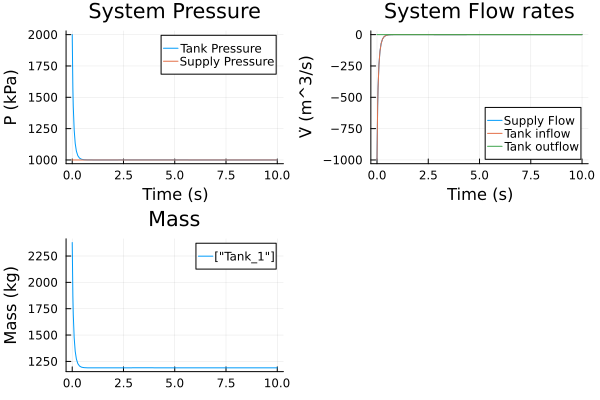

In [84]:
using ModelingToolkit, DifferentialEquations
#= Example 1: Charging Tank =#
Tank1 = IsothermalGasRigidControlVolume(:Tank1; temperature = 293, volume = 100, initial_pressure = 2e6)
Rflow = IsothermalGasFlowResistance(:Rflow; R = 1000)

subsys = [Tank1, Rflow]

conn = vcat(flowConnect(Rflow.n, Tank1.p),
                        [Rflow.p.P ~ 1e6],
                        flowCap(Tank1.n))

sysbuild = compose(ODESystem(conn, t, name = :sysbuild), subsys)
@show mtk.getdefault(sysbuild.Tank1.m)
sys = structural_simplify(sysbuild)
prob = ODEProblem(sys,u0,(0,10))
sol = solve(prob)
pressure_fig = plot(sol.t, [sol[sys.Tank1.p.P] ./ 10^3, sol[sys.Rflow.p.P] ./10^3]; 
                    label=["Tank Pressure" "Supply Pressure"], 
                    title = "System Pressure", 
                    ylabel = "P (kPa)",
                    xlabel = "Time (s)")

vflow_fig = plot(sol.t, [sol[sys.Tank1.p.dV], sol[sys.Rflow.p.dV], sol[sys.Tank1.n.dV]]; 
                    label=["Supply Flow" "Tank inflow" "Tank outflow"], 
                    title = "System Flow rates", 
                    ylabel = "V̇ (m^3/s)",
                    xlabel = "Time (s)")

mplot = plot(sol.t,[(sol[Tank1.m])], label = ["Tank_1"], title = "Mass",
    ylabel = "Mass (kg)")
plot(pressure_fig, vflow_fig, mplot)

### Coupled Thermo-Mechanical

In [ ]:
function thermoTwoPort(name;
                initial_pressure = 101325,
                initial_temperature = 300,
                gas_constant = 287,
                isochoric_specific_heat = 718)

    q1 = thermal_dof(:q1; initial_temperature = initial_temperature);
    f1 = mechanical_dof(:f1; initial_pressure = initial_pressure);

    mtk.@variables dm(t) = 0.0
    

    # state variables
    #   q̇ = [q1.dS, f1.dV]
    # but
    #
    #   P = f(s,V)
    #   T = f(s,V)


end

In [ ]:
#===================================
Multi DOmain
===================================#
function thermoMechanical_dof(name;
    initial_pressure = 101325,
    initial_temperature = 300,
    gas_constant = 287,
    isochoric_specific_heat = 718)

q = thermal_dof(:q; initial_temperature = initial_temperature);
f = mechanical_dof(:f; initial_pressure = initial_pressure);
mtk.@parameters Rg = gas_constant                                                   [description = "Gas constant J/kg/K, default for air"]
mtk.@parameters cv = isochoric_specific_heat                                        [description = "Cv = dU/DT at constant volume, default for air"]
mtk.@variables s(t) = 0                                                             [description = "Specific entropy of ideal gas"]
mtk.@variables v(t) = Rg * initial_temperature / initial_pressure                   [description = "Specific volume of ideal gas"]
mtk.@variables dm(t)=0.0                                                            [description = "Mass flow rate (kg/s)"]

eqns = [q.dS ~ dm * s,
f.dV ~ dm * v,
D(s) ~ cv / q.T * D(q.T) + Rg / v * D(v)]
mtk.extend(mtk.ODESystem(eqns,t, [s,v,dm],[Rg,cv]; name = name, metadata = Dict(:eltype => :port)),mtk.extend(f,q))
end




function thermoMechanicalOnePort(name;
                                port_volume = 1.0,
                                gas_constant = 287,
                                isochoric_specific_heat = 718)

    g1 = thermoMechanical_dof(:g1; gas_constant = gas_constant,
                            isochoric_specific_heat =  isochoric_specific_heat)
    g2 = thermoMechanical_dof(:g2; gas_constant = gas_constant,
                            isochoric_specific_heat =  isochoric_specific_heat)

    mtk.@parameters V = port_volume     [description = "Port Volume constant"]
    mtk.@variables T(t)=0.0             [description = "Temperature drop from port 1 to 2 (T = T1 - T2) [K]"]
    mtk.@variables P(t)=0.0             [description = "Pressure drop from port 1 to 2 (P = P1 - P2) [Pa]"]
    mtk.@variables S(t)=0.0             [description = "Total entropy of a one port element [kg]"]
    mtk.@variables m(t)=0.0             [description = "mass of the thermomechanical one port element [kg]"]
    eqns = [
    D(m) ~ g1.dm + g2.dm,
    D(S) ~ g1.dS + g2.dS,
    T   ~ g1.T - g2.T,
    P   ~ g1.P - g2.P]
    mtk.compose(mtk.ODESystem(eqns, t, [T,P,S,m],[V],  name = name), g1,g2)
end

g1 = thermoMechanical_dof(:g1)
tmp = thermoMechanicalOnePort(:tmp)


C-field
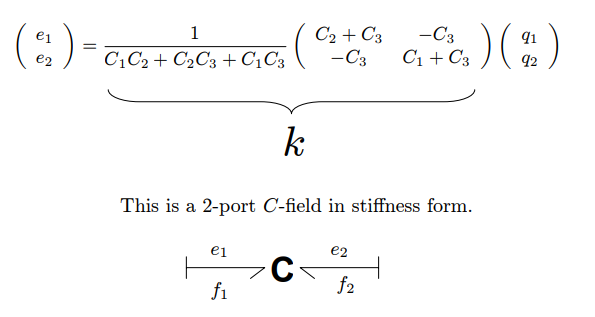

e = kq
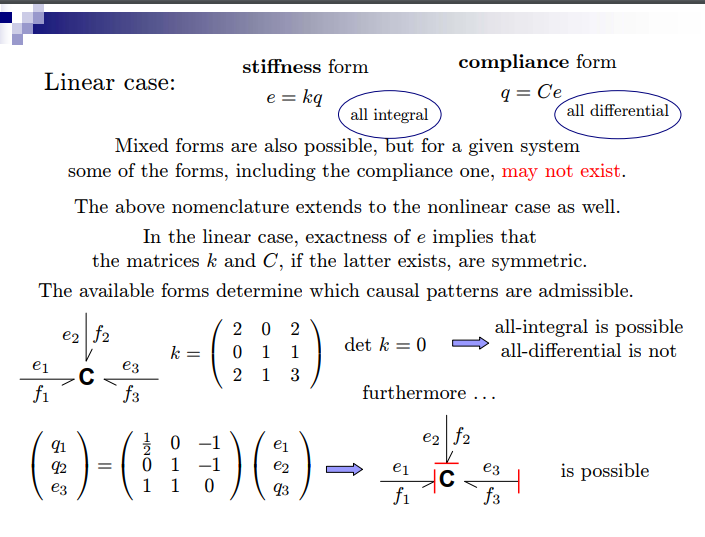

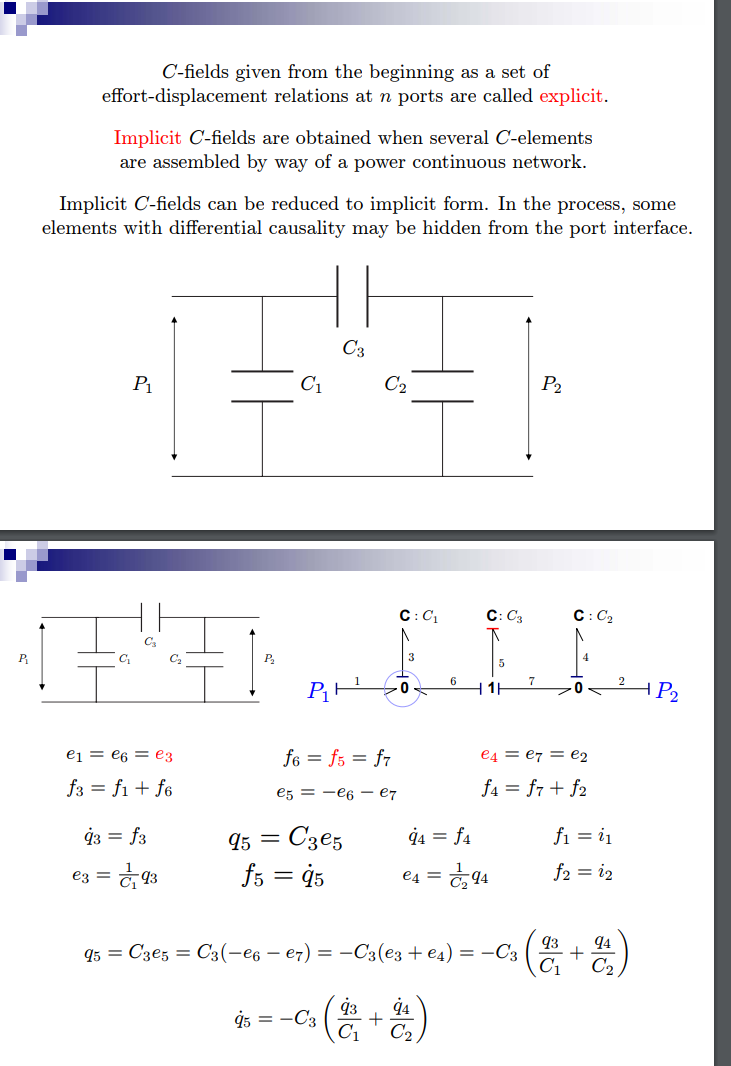